# Create a ball and stick neurons and save it to swc

In [100]:
import pandas as pd
import numpy as np

def make_ball_and_stick_neuron(
    n_sticks=2,
    angles_deg=None,
    length=90,
    n_segments=8,
    soma_radius=10,
    stick_radius_profile=(2, 1),
    n_varicosities=0,
    varicosity_scale=1.5,
    seed=None
):
    """
    Create a ball-and-stick neuron model with optional varicosities.

    Parameters
    ----------
    n_sticks : int
        Number of dendritic sticks to attach to the soma.
    angles_deg : list of float, optional
        Angles (in degrees) for each stick in XY plane.
        If None, evenly spaced around soma.
    length : float
        Total length of each stick.
    n_segments : int
        Number of segments per stick.
    soma_radius : float
        Radius of the soma sphere.
    stick_radius_profile : tuple(float, float)
        (start_radius, end_radius) along each stick.
    n_varicosities : int
        Total number of varicosities (radius-enlarged nodes).
    varicosity_scale : float
        Factor by which the radius is multiplied at varicosity nodes.
    seed : int, optional
        Random seed for reproducibility.

    Returns
    -------
    nodes : pd.DataFrame
        Columns: id, ntype, x, y, z, r, parent
    """
    if seed is not None:
        np.random.seed(seed)

    if angles_deg is None:
        angles_deg = np.linspace(0, 360, n_sticks, endpoint=False)
    elif len(angles_deg) != n_sticks:
        raise ValueError("Length of angles_deg must match n_sticks")

    nodes = []
    node_id = 1

    # Soma
    nodes.append(dict(
        id=node_id,
        ntype=1,
        x=0, y=0, z=0,
        r=soma_radius,
        parent=-1
    ))
    soma_id = node_id
    node_id += 1

    # Keep track of dendritic node indices for varicosities
    dendritic_ids = []

    # Build sticks
    for angle in angles_deg:
        rad = np.deg2rad(angle)
        x_dir, y_dir = np.cos(rad), np.sin(rad)

        # Make offset such that first segment starts at soma surface, take angle into account
        offset_x = x_dir * soma_radius
        offset_y = y_dir * soma_radius

        xs = np.linspace(0, length * x_dir, n_segments + 1)[1:] + offset_x
        ys = np.linspace(0, length * y_dir, n_segments + 1)[1:] + offset_y
        rs = np.linspace(stick_radius_profile[0], stick_radius_profile[1], n_segments + 1)[1:]

        parent = soma_id
        for xi, yi, ri in zip(xs, ys, rs):
            nodes.append(dict(
                id=node_id,
                ntype=3,
                x=xi, y=yi, z=0,
                r=ri,
                parent=parent
            ))
            dendritic_ids.append(node_id)
            parent = node_id
            node_id += 1

    df = pd.DataFrame(nodes)

    # Apply varicosities
    if n_varicosities > 0 and len(dendritic_ids) > 0:
        n_varicosities = min(n_varicosities, len(dendritic_ids))
        varico_nodes = np.random.choice(dendritic_ids, n_varicosities, replace=False)
        df.loc[df["id"].isin(varico_nodes), "r"] *= varicosity_scale

    return df


In [148]:
import pandas as pd

neuron = make_ball_and_stick_neuron(
    n_sticks=2,
    angles_deg=[0, 90],
    length=90,
    n_segments=100,
    stick_radius_profile=(1, 1),
    soma_radius=10,
    n_varicosities=5,
    varicosity_scale=3,
    seed=80
)

neuron_path = "data/ball_and_stick_neuron_v1.swc"
display(neuron)
neuron.to_csv(neuron_path, index=False, header=False, sep=' ')

,id,ntype,x,y,z,r,parent
0,1,1,0.000000e+00,0.0,0,10.0,-1
1,2,3,1.090000e+01,0.0,0,1.0,1
2,3,3,1.180000e+01,0.0,0,1.0,2
3,4,3,1.270000e+01,0.0,0,1.0,3
4,5,3,1.360000e+01,0.0,0,1.0,4
...,...,...,...,...,...,...,...
196,197,3,5.902798e-15,96.4,0,1.0,196
197,198,3,5.957907e-15,97.3,0,1.0,197
198,199,3,6.013016e-15,98.2,0,1.0,198
199,200,3,6.068125e-15,99.1,0,1.0,199


In [149]:
import skeliner as sk

skel = sk.io.load_swc(neuron_path)

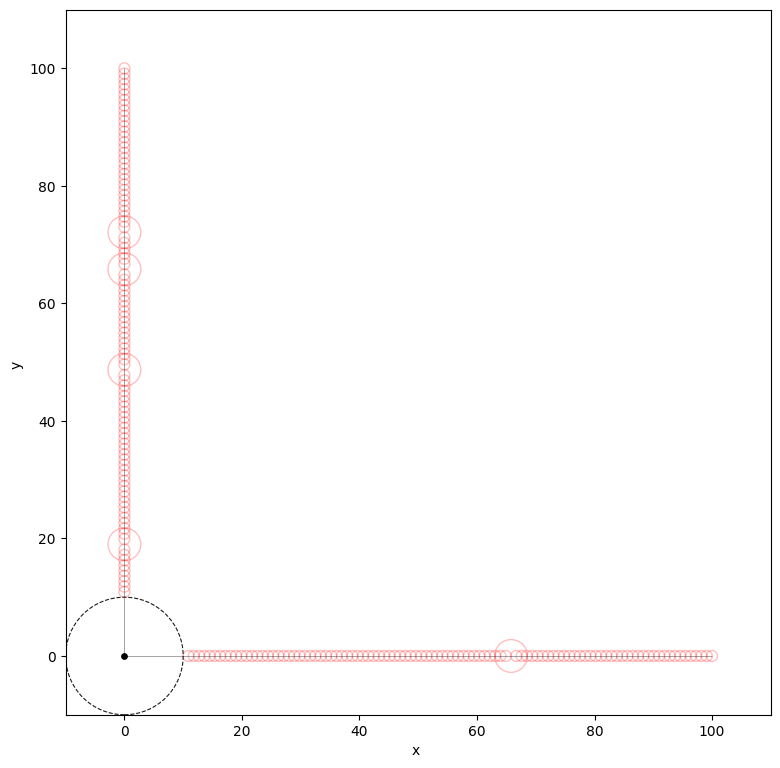

In [150]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sk.plot.projection(ax=ax, skel=skel, plane='xy')
ax.set_aspect('equal', 'box')
ax.set_xlim(skel.nodes[:, 0].min() - 10, skel.nodes[:, 0].max() + 10)
ax.set_ylim(skel.nodes[:, 1].min() - 10, skel.nodes[:, 1].max() + 10)
plt.show()

In [151]:
import numpy as np
import trimesh

# Inputs: `skel` object with .edges, .nodes, .radii attributes

parts = []

# Create sphere for soma (first node, index 0)
soma_pos = skel.nodes[0]
soma_radius = float(skel.radii['mean'][0])
soma_sphere = trimesh.creation.icosphere(subdivisions=3, radius=soma_radius)
soma_sphere.apply_translation(soma_pos)
parts.append(soma_sphere)

# Create tapered cylinders (frustums) for all edges
for u, v in skel.edges:
    p0, p1 = skel.nodes[u], skel.nodes[v]
    r0, r1 = float(skel.radii['mean'][u]), float(skel.radii['mean'][v])

    # Calculate direction and height
    direction = p1 - p0
    height = np.linalg.norm(direction)

    if height < 1e-8:  # Skip degenerate edges
        continue

    # Create tapered cylinder (frustum) - trimesh doesn't have a built-in frustum,
    # so we'll create one manually
    direction_norm = direction / height

    # Create a frustum by making vertices at two circular cross-sections
    n_segments = 16  # Number of segments around the circle
    angles = np.linspace(0, 2 * np.pi, n_segments, endpoint=False)

    # Bottom circle (at p0 with radius r0)
    circle_2d = np.column_stack([np.cos(angles), np.sin(angles), np.zeros(n_segments)])
    bottom_verts = circle_2d * r0

    # Top circle (at p1 with radius r1)
    top_verts = circle_2d * r1
    top_verts[:, 2] = height

    # Combine vertices
    vertices = np.vstack([bottom_verts, top_verts])

    # Create faces for the sides
    faces = []
    for i in range(n_segments):
        next_i = (i + 1) % n_segments
        # Two triangles per quad
        faces.append([i, next_i, n_segments + i])
        faces.append([next_i, n_segments + next_i, n_segments + i])

    # Add bottom cap (if radius > 0)
    if r0 > 1e-8:
        bottom_center_idx = len(vertices)
        vertices = np.vstack([vertices, [0, 0, 0]])
        for i in range(n_segments):
            next_i = (i + 1) % n_segments
            faces.append([bottom_center_idx, next_i, i])

    # Add top cap (if radius > 0)
    if r1 > 1e-8:
        top_center_idx = len(vertices)
        vertices = np.vstack([vertices, [0, 0, height]])
        for i in range(n_segments):
            next_i = (i + 1) % n_segments
            faces.append([top_center_idx, n_segments + i, n_segments + next_i])

    # Create mesh
    frustum = trimesh.Trimesh(vertices=vertices, faces=faces)

    # Create transformation matrix to align and position frustum
    z_axis = np.array([0, 0, 1])
    if np.allclose(direction_norm, z_axis):
        rotation = np.eye(4)
    elif np.allclose(direction_norm, -z_axis):
        rotation = np.eye(4)
        rotation[:3, :3] = np.diag([1, -1, -1])
    else:
        # Use rotation matrix from z-axis to direction
        v = np.cross(z_axis, direction_norm)
        s = np.linalg.norm(v)
        c = np.dot(z_axis, direction_norm)
        vx = np.array([[0, -v[2], v[1]],
                       [v[2], 0, -v[0]],
                       [-v[1], v[0], 0]])
        rotation = np.eye(4)
        rotation[:3, :3] = np.eye(3) + vx + vx @ vx * ((1 - c) / (s ** 2))

    # Add translation to start point (p0)
    rotation[:3, 3] = p0

    frustum.apply_transform(rotation)
    parts.append(frustum)

# Concatenate all parts (soma sphere + edge frustums)
combined = trimesh.util.concatenate(parts)

# For actual boolean union (slower but cleaner):
# combined = trimesh.boolean.union(parts, engine='blender')  # or 'scad'

# Export (make sure neuron_path is defined)
mesh_path = neuron_path.replace(".swc", ".ply")
combined.export(mesh_path)

b'ply\nformat binary_little_endian 1.0\ncomment https://github.com/mikedh/trimesh\nelement vertex 7442\nproperty float x\nproperty float y\nproperty float z\nelement face 14080\nproperty list uchar int vertex_indices\nend_header\n\xe5;\xa8\xc0\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8@\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8\xc0\xa8\x1a\x08\xc1\x00\x00\x00\x00\xe5;\xa8@\xa8\x1a\x08\xc1\x00\x00\x00\x00\x00\x00\x00\x00\xe5;\xa8\xc0\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8@\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8\xc0\xa8\x1a\x08\xc1\x00\x00\x00\x00\xe5;\xa8@\xa8\x1a\x08\xc1\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8\xc0\xa8\x1a\x08A\x00\x00\x00\x00\xe5;\xa8@\xa8\x1a\x08\xc1\x00\x00\x00\x00\xe5;\xa8\xc0\xa8\x1a\x08\xc1\x00\x00\x00\x00\xe5;\xa8@\x00\x00\x00\x00\x00\x00 A\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \xc1\x00\x00\x00\x00X\xc5E\xc0Vq\x01\xc1\x00\x00\xa0@X\xc5E@Vq\x01\xc1\x00\x00\xa0@X\xc5E\xc0Vq\x01A\x00\x00\xa0@X\xc5E@Vq\x01A\x00\x00\xa0@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 AX\xc5E\xc0Vq\x01\

In [152]:
mesh = sk.io.load_mesh(mesh_path)
skel_from_mesh = sk.skeletonize(mesh=mesh)

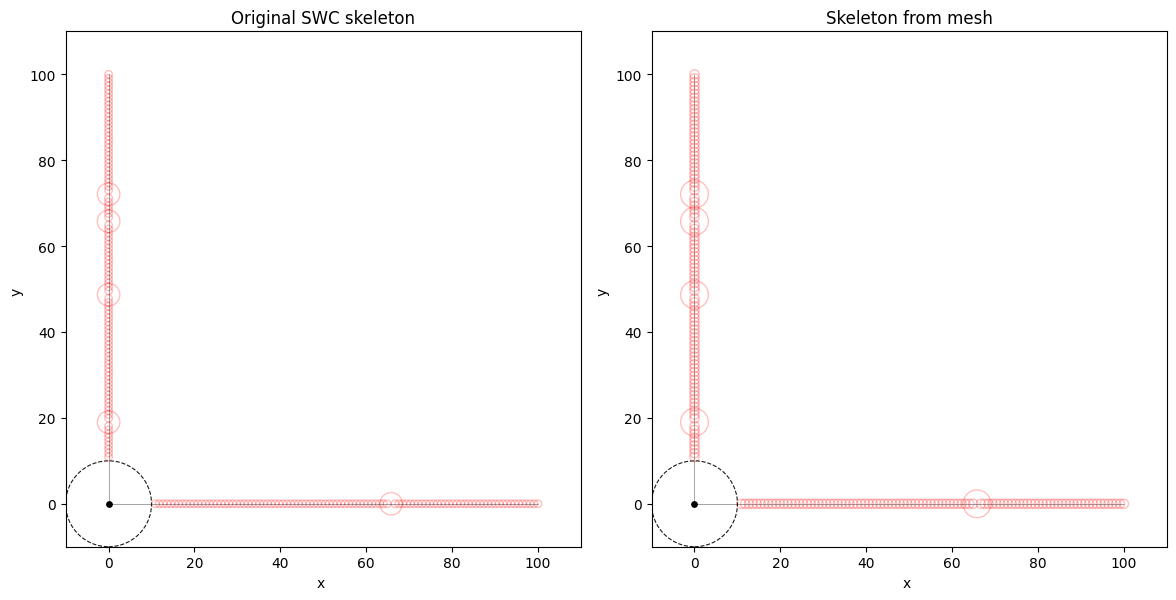

In [153]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for i, skel_i in enumerate([skel, skel_from_mesh]):
    ax = axs[i]
    sk.plot.projection(ax=ax, skel=skel, plane='xy')
    ax.set_aspect('equal', 'box')
    ax.set_xlim(skel.nodes[:, 0].min() - 10, skel.nodes[:, 0].max() + 10)
    ax.set_ylim(skel.nodes[:, 1].min() - 10, skel.nodes[:, 1].max() + 10)

axs[0].set_title("Original SWC skeleton")
axs[1].set_title("Skeleton from mesh")

plt.show()

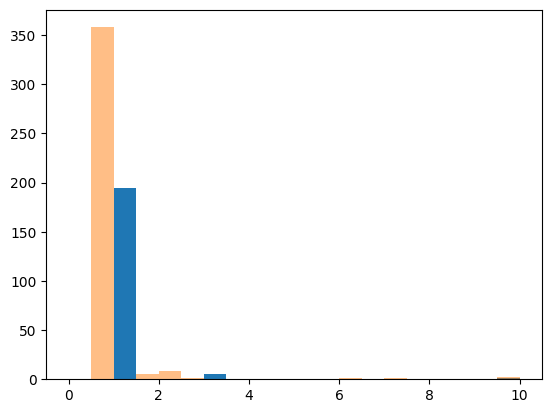

In [155]:
plt.hist(skel.radii['trim'], bins=np.linspace(0, 10, 21))
plt.hist(skel_from_mesh.radii['trim'], alpha=0.5, bins=np.linspace(0, 10, 21))
plt.show()